In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import re
import seaborn as sns
sns.set_palette('colorblind')

# Read and Preprocess images

In [2]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('data')):
    for filename in tqdm(sorted(filenames)):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data, dtype='object')

100%|██████████| 2048/2048 [00:00<00:00, 3433.20it/s]


In [3]:
def pad_images(images, target_shape):
    padded_images = []

    for image in images:
        old_shape = image.shape
        pad_width = [(0, max(0, new_dim - old_dim)) for old_dim, new_dim in zip(old_shape, target_shape)]
        padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)
        padded_images.append(padded_image)

    return np.array(padded_images)

In [4]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
padded_data.shape

(2048, 256, 256, 1)

In [5]:
# Transpose to feed into torch model
data_t = np.transpose(padded_data, (0, 3, 1, 2))

In [6]:
X = data_t.copy()/255
y = pd.read_csv('label.csv')['label'].values
del padded_data
del data_t
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
del X, y
torch.cuda.empty_cache()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#define data loaders
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to(device=device, dtype=torch.float), torch.from_numpy(y_train).to(device=device, dtype=torch.float))
#val_data = torch.utils.data.TensorDataset(torch.from_numpy(X_val).to(device=device, dtype=torch.float), torch.from_numpy(y_val).to(device=device, dtype=torch.float))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test).to(device=device, dtype=torch.float), torch.from_numpy(y_test).to(device=device, dtype=torch.float))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

del X_train, y_train, train_data, test_data

torch.cuda.empty_cache()


# Model Construction

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Define the Regression Model
class RegressionModel(nn.Module):
    def __init__(self, resnet_backbone, num_classes=1):
        super(RegressionModel, self).__init__()
        self.resnet = resnet_backbone
        # Modify the first layer to accept 1 channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Mish(),
            nn.Linear(256, 64),
            nn.Mish(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        features = self.resnet(x)
        output = self.linear_layers(features)
        return output

# Load the pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Create the regression model with ResNet as the backbone
regression_model = RegressionModel(resnet)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(regression_model.parameters(), lr=0.001)

# Training loop
num_epochs =150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model.to(device)
train_loss = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    val_loss = []

    for images, targets in train_loader:
        regression_model.train()
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = regression_model(images)
        loss = criterion(outputs.squeeze(), targets.float()) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #validate
        regression_model.eval()
        total_val_loss = 0
        #with torch.no_grad():
        #    for images, targets in val_loader:
        #        images, targets = images.to(device), targets.to(device)
        #        outputs = regression_model(images)
        #        loss = criterion(outputs.squeeze(), targets.float())
        #        total_val_loss += loss.item()
        #    avg_val_loss = total_val_loss / len(val_loader) 
    #val_loss.append(avg_val_loss)
    train_loss.append(total_loss / len(train_loader))

    


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")
    #print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss/len(val_loader)}")


/home/luiz_facury/miniconda3/envs/whisper/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luiz_facury/miniconda3/envs/whisper/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  1%|          | 1/150 [00:07<18:45,  7.56s/it]

Epoch 1/150, Loss: 58667.37592022236


  1%|▏         | 2/150 [00:14<17:18,  7.02s/it]

Epoch 2/150, Loss: 9411.79550405649


  2%|▏         | 3/150 [00:20<16:46,  6.85s/it]

Epoch 3/150, Loss: 2953.451352632963


  3%|▎         | 4/150 [00:27<16:27,  6.77s/it]

Epoch 4/150, Loss: 2495.912534273588


  3%|▎         | 5/150 [00:34<16:14,  6.72s/it]

Epoch 5/150, Loss: 4443.373427170974


  4%|▍         | 6/150 [00:40<16:04,  6.70s/it]

Epoch 6/150, Loss: 2930.0064227764424


  5%|▍         | 7/150 [00:47<15:55,  6.68s/it]

Epoch 7/150, Loss: 1711.892099233774


  5%|▌         | 8/150 [00:54<15:46,  6.67s/it]

Epoch 8/150, Loss: 1727.8032789963943


  6%|▌         | 9/150 [01:00<15:39,  6.66s/it]

Epoch 9/150, Loss: 1983.003638634315


  7%|▋         | 10/150 [01:07<15:31,  6.66s/it]

Epoch 10/150, Loss: 9285.553489098182


  7%|▋         | 11/150 [01:13<15:24,  6.65s/it]

Epoch 11/150, Loss: 5372.624863844651


  8%|▊         | 12/150 [01:20<15:17,  6.65s/it]

Epoch 12/150, Loss: 2848.8109459510215


  9%|▊         | 13/150 [01:27<15:10,  6.65s/it]

Epoch 13/150, Loss: 1705.0720073993389


  9%|▉         | 14/150 [01:33<15:03,  6.64s/it]

Epoch 14/150, Loss: 1822.5507272573618


 10%|█         | 15/150 [01:40<14:57,  6.64s/it]

Epoch 15/150, Loss: 3878.5799936147837


 11%|█         | 16/150 [01:47<14:50,  6.64s/it]

Epoch 16/150, Loss: 2217.08200777494


 11%|█▏        | 17/150 [01:53<14:46,  6.67s/it]

Epoch 17/150, Loss: 1268.3963505671575


 12%|█▏        | 18/150 [02:00<14:45,  6.71s/it]

Epoch 18/150, Loss: 1474.8400738055889


 13%|█▎        | 19/150 [02:07<14:43,  6.75s/it]

Epoch 19/150, Loss: 1544.214092548077


 13%|█▎        | 20/150 [02:14<14:41,  6.78s/it]

Epoch 20/150, Loss: 1515.8811839177058


 14%|█▍        | 21/150 [02:21<14:37,  6.80s/it]

Epoch 21/150, Loss: 1497.98681640625


 15%|█▍        | 22/150 [02:28<14:32,  6.82s/it]

Epoch 22/150, Loss: 799.12963280311


 15%|█▌        | 23/150 [02:34<14:27,  6.83s/it]

Epoch 23/150, Loss: 840.8552492581881


 16%|█▌        | 24/150 [02:41<14:20,  6.83s/it]

Epoch 24/150, Loss: 871.7906001164363


 17%|█▋        | 25/150 [02:48<14:18,  6.86s/it]

Epoch 25/150, Loss: 1679.8970559927134


 17%|█▋        | 26/150 [02:55<14:12,  6.87s/it]

Epoch 26/150, Loss: 825.3587394127479


 18%|█▊        | 27/150 [03:02<14:05,  6.87s/it]

Epoch 27/150, Loss: 1597.0726459209736


 19%|█▊        | 28/150 [03:09<13:57,  6.87s/it]

Epoch 28/150, Loss: 1358.6601198636567


 19%|█▉        | 29/150 [03:16<13:52,  6.88s/it]

Epoch 29/150, Loss: 1189.3839530944824


 20%|██        | 30/150 [03:23<13:45,  6.88s/it]

Epoch 30/150, Loss: 1093.5574596111592


 21%|██        | 31/150 [03:30<13:40,  6.90s/it]

Epoch 31/150, Loss: 737.6669596158541


 21%|██▏       | 32/150 [03:36<13:33,  6.90s/it]

Epoch 32/150, Loss: 1428.7077833322378


 22%|██▏       | 33/150 [03:43<13:26,  6.89s/it]

Epoch 33/150, Loss: 822.1563788193923


 23%|██▎       | 34/150 [03:50<13:19,  6.89s/it]

Epoch 34/150, Loss: 913.5643938504733


 23%|██▎       | 35/150 [03:57<13:12,  6.89s/it]

Epoch 35/150, Loss: 766.7873353224534


 24%|██▍       | 36/150 [04:04<13:05,  6.89s/it]

Epoch 36/150, Loss: 592.8626133845403


 24%|██▍       | 36/150 [04:06<13:01,  6.85s/it]


KeyboardInterrupt: 

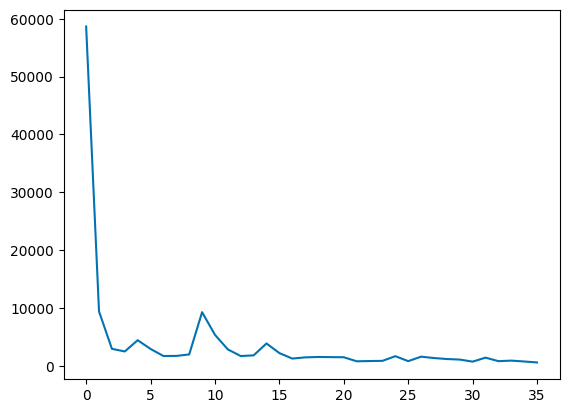

In [11]:
#plt.plot(val_loss, label   ='Validation loss')
plt.plot(train_loss, label='Training loss')

In [12]:
regression_model.eval()
total_test_loss = 0
yhat = []
y = []
with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = regression_model(images)
        yhat.append(outputs.squeeze().cpu().numpy().tolist())
        y.append(targets.cpu().numpy().tolist())
        loss = criterion(outputs.squeeze(), targets.float())  
        total_test_loss += loss.item()

avg_test_loss = np.sqrt(total_test_loss / len(test_loader))
print(f"Test RMSE: {avg_test_loss}")

y = np.array(y, dtype=object)
yhat = np.array(yhat , dtype=object)
y = np.concatenate(y)
#yhat = np.concatenate(yhat)

/home/luiz_facury/miniconda3/envs/whisper/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE: 17.639283931965725


In [13]:
df = pd.DataFrame(columns=['yhat', 'y'])
df['yhat'] = yhat
df['y'] = y
df.sort_values(by=['y'], inplace=True)

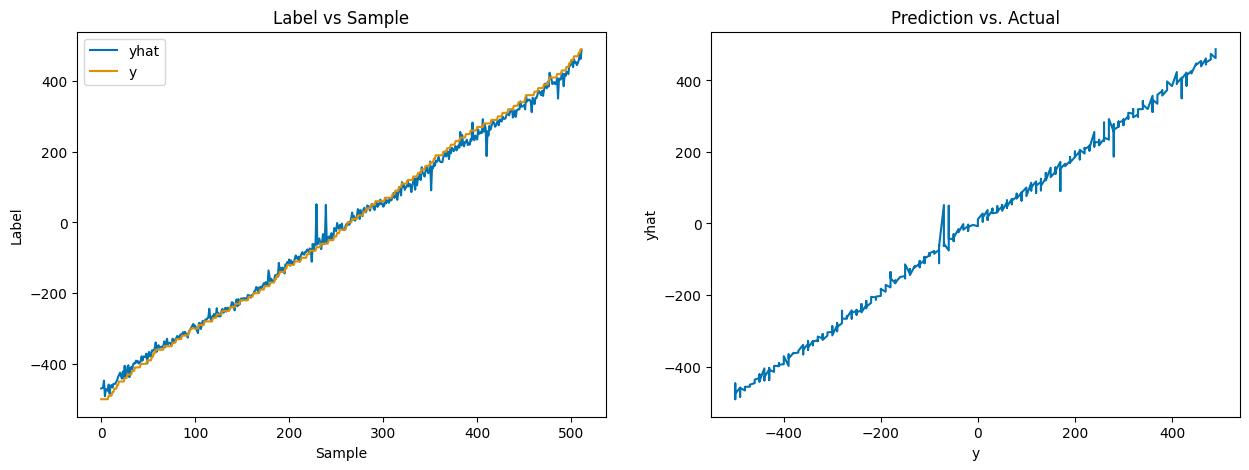

In [14]:
#create suplot with 2 columns and 1 row
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(df['yhat'].values)
ax[0].plot(df['y'].values)
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Label')
ax[0].legend(['yhat', 'y'])
ax[0].set_title('Label vs Sample')

ax[1].plot(df['y'].values, df['yhat'].values)
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Prediction vs. Actual')

plt.show()

In [15]:
df

yhat      y
131 -469.588562 -500.0
136 -468.512878 -500.0
498 -467.269348 -500.0
182 -447.355713 -500.0
171 -491.430145 -500.0
..          ...    ...
502  450.371887  470.0
459  458.466492  480.0
229  474.321655  480.0
464  462.479767  490.0
228  487.331909  490.0

[512 rows x 2 columns]

# Test with the new video data

In [16]:
del train_loader
del test_loader
torch.cuda.empty_cache()

In [17]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('data2')):
    for filename in tqdm(sorted(filenames, key=lambda x: int(re.sub('\D', '', x)))):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data)/255

100%|██████████| 442/442 [00:00<00:00, 6326.44it/s]


In [18]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
data_t = np.transpose(padded_data, (0, 3, 1, 2))
data_t = torch.from_numpy(data_t).to(device)

In [19]:
dl = DataLoader(data_t, batch_size=40, shuffle=False)

In [20]:
yhats = []
imgs = []
for i in dl:
    yhat = regression_model (i)
    imgs.append(i.detach().cpu().numpy())
    yhats.append(yhat.detach().cpu().numpy())
    del yhat
    torch.cuda.empty_cache()

In [21]:
yhats = np.concatenate(yhats)
imgs = np.concatenate(imgs)

In [22]:
imgs = np.transpose(imgs, (0,2,3,1))

/tmp/ipykernel_8417/1078603152.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[i]))


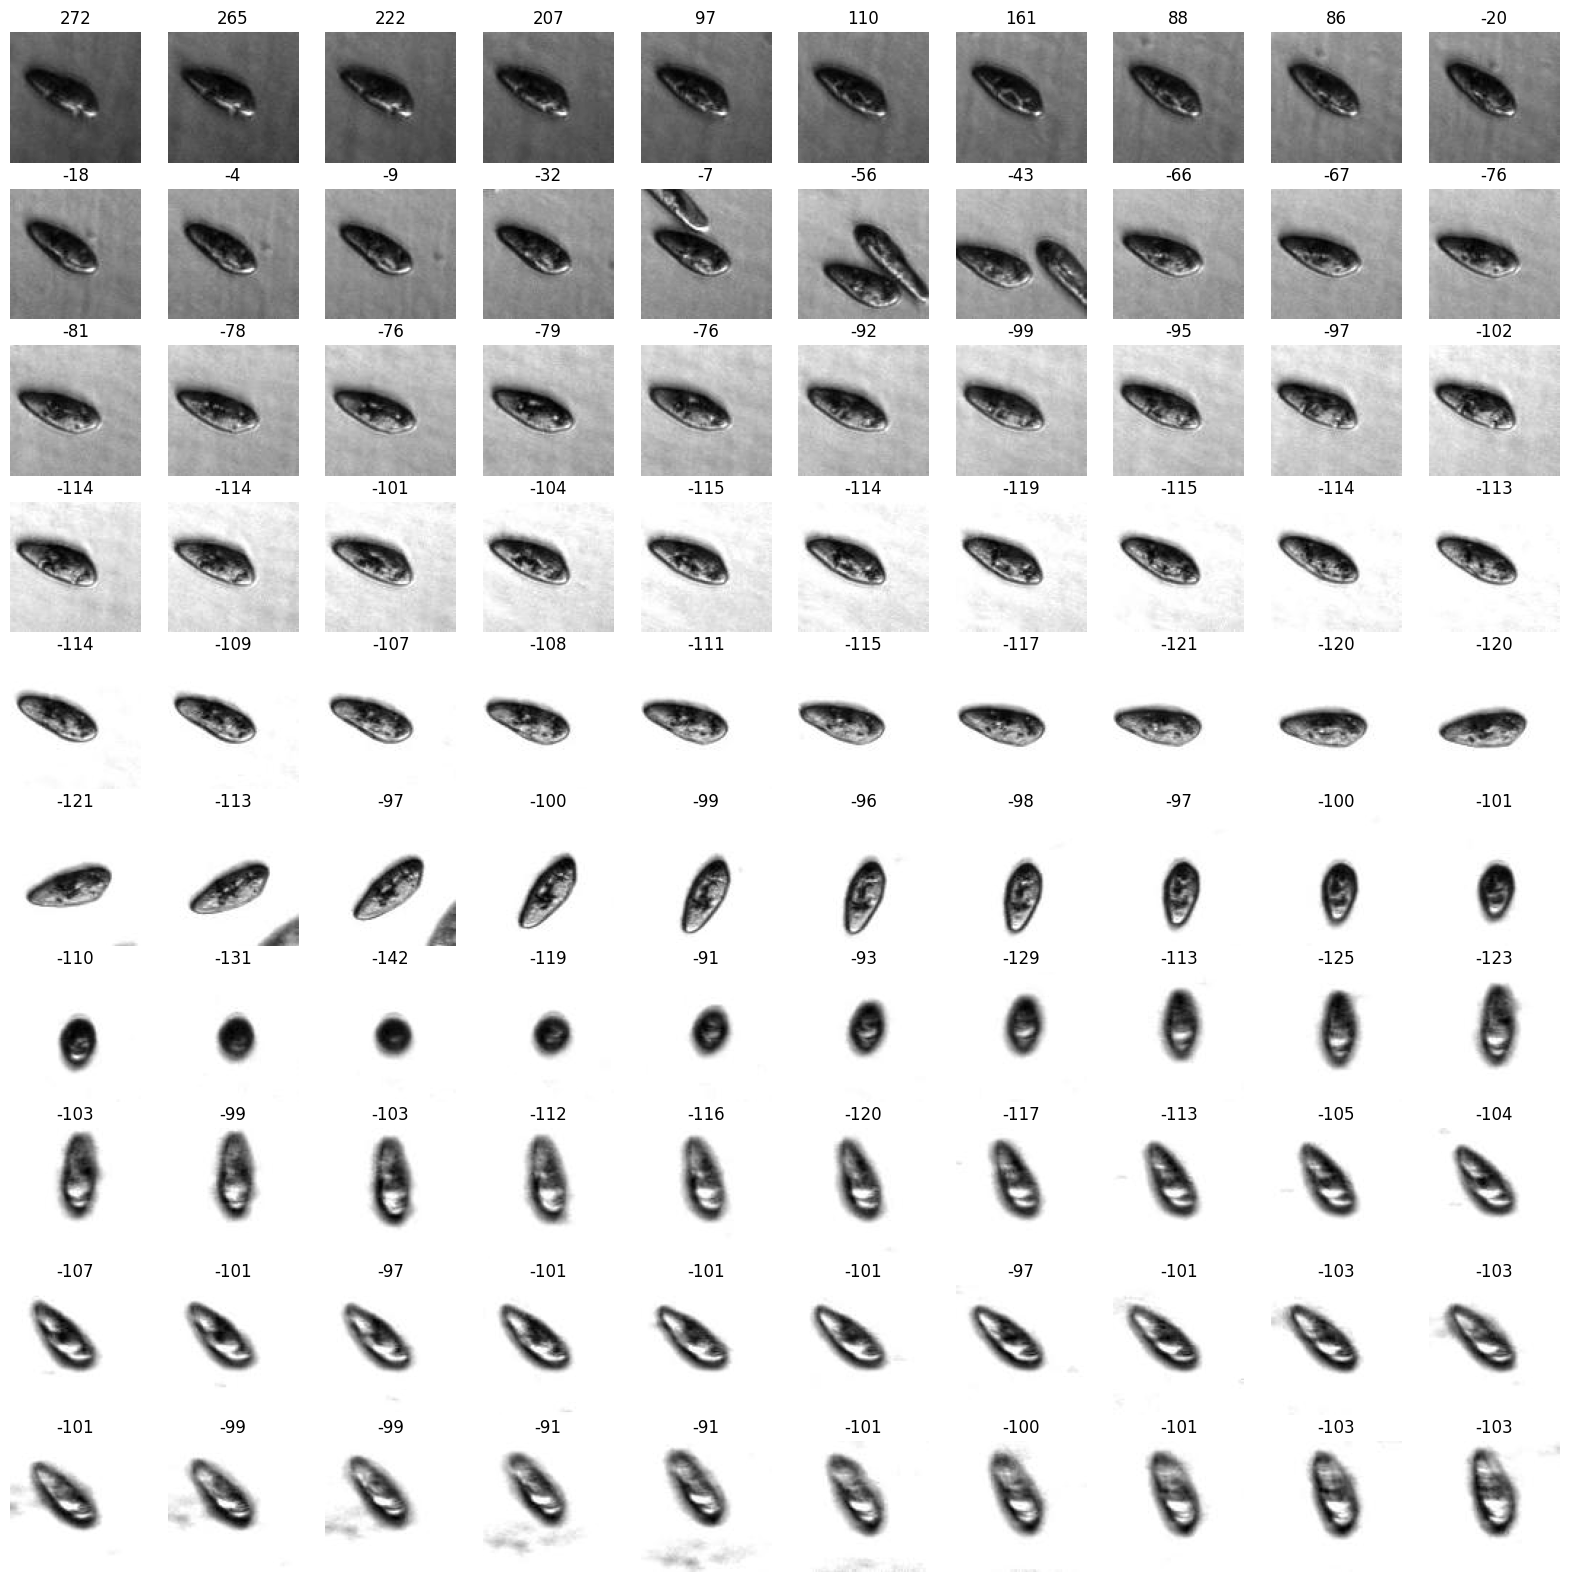

In [35]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax[i//10, i%10].imshow(imgs[i, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[i]))
    ax[i//10, i%10].axis('off')

/tmp/ipykernel_8417/1689807850.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[j]))


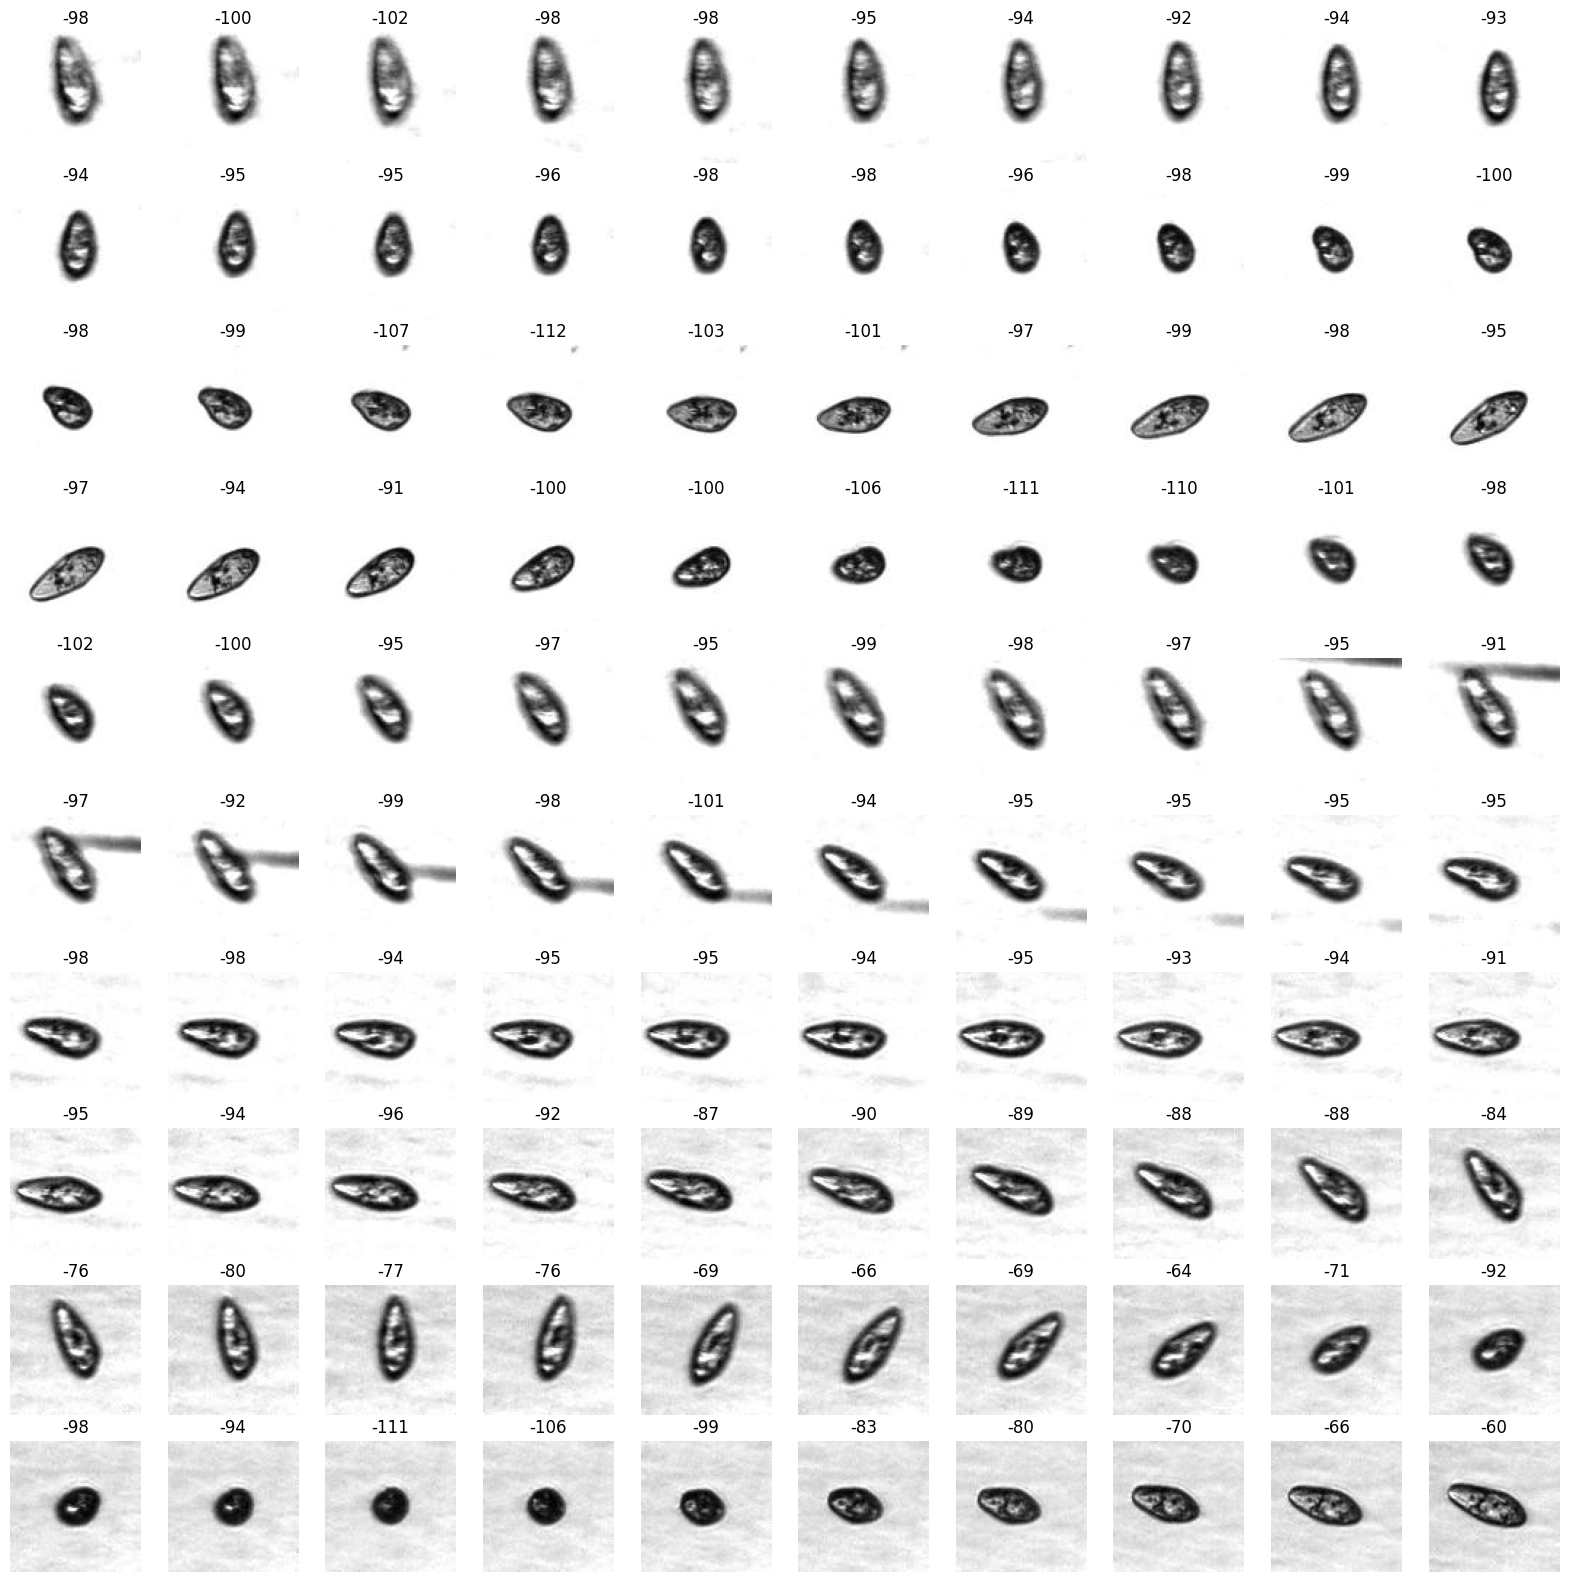

In [34]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(100, 200)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')

/tmp/ipykernel_8417/1970056730.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[j]))


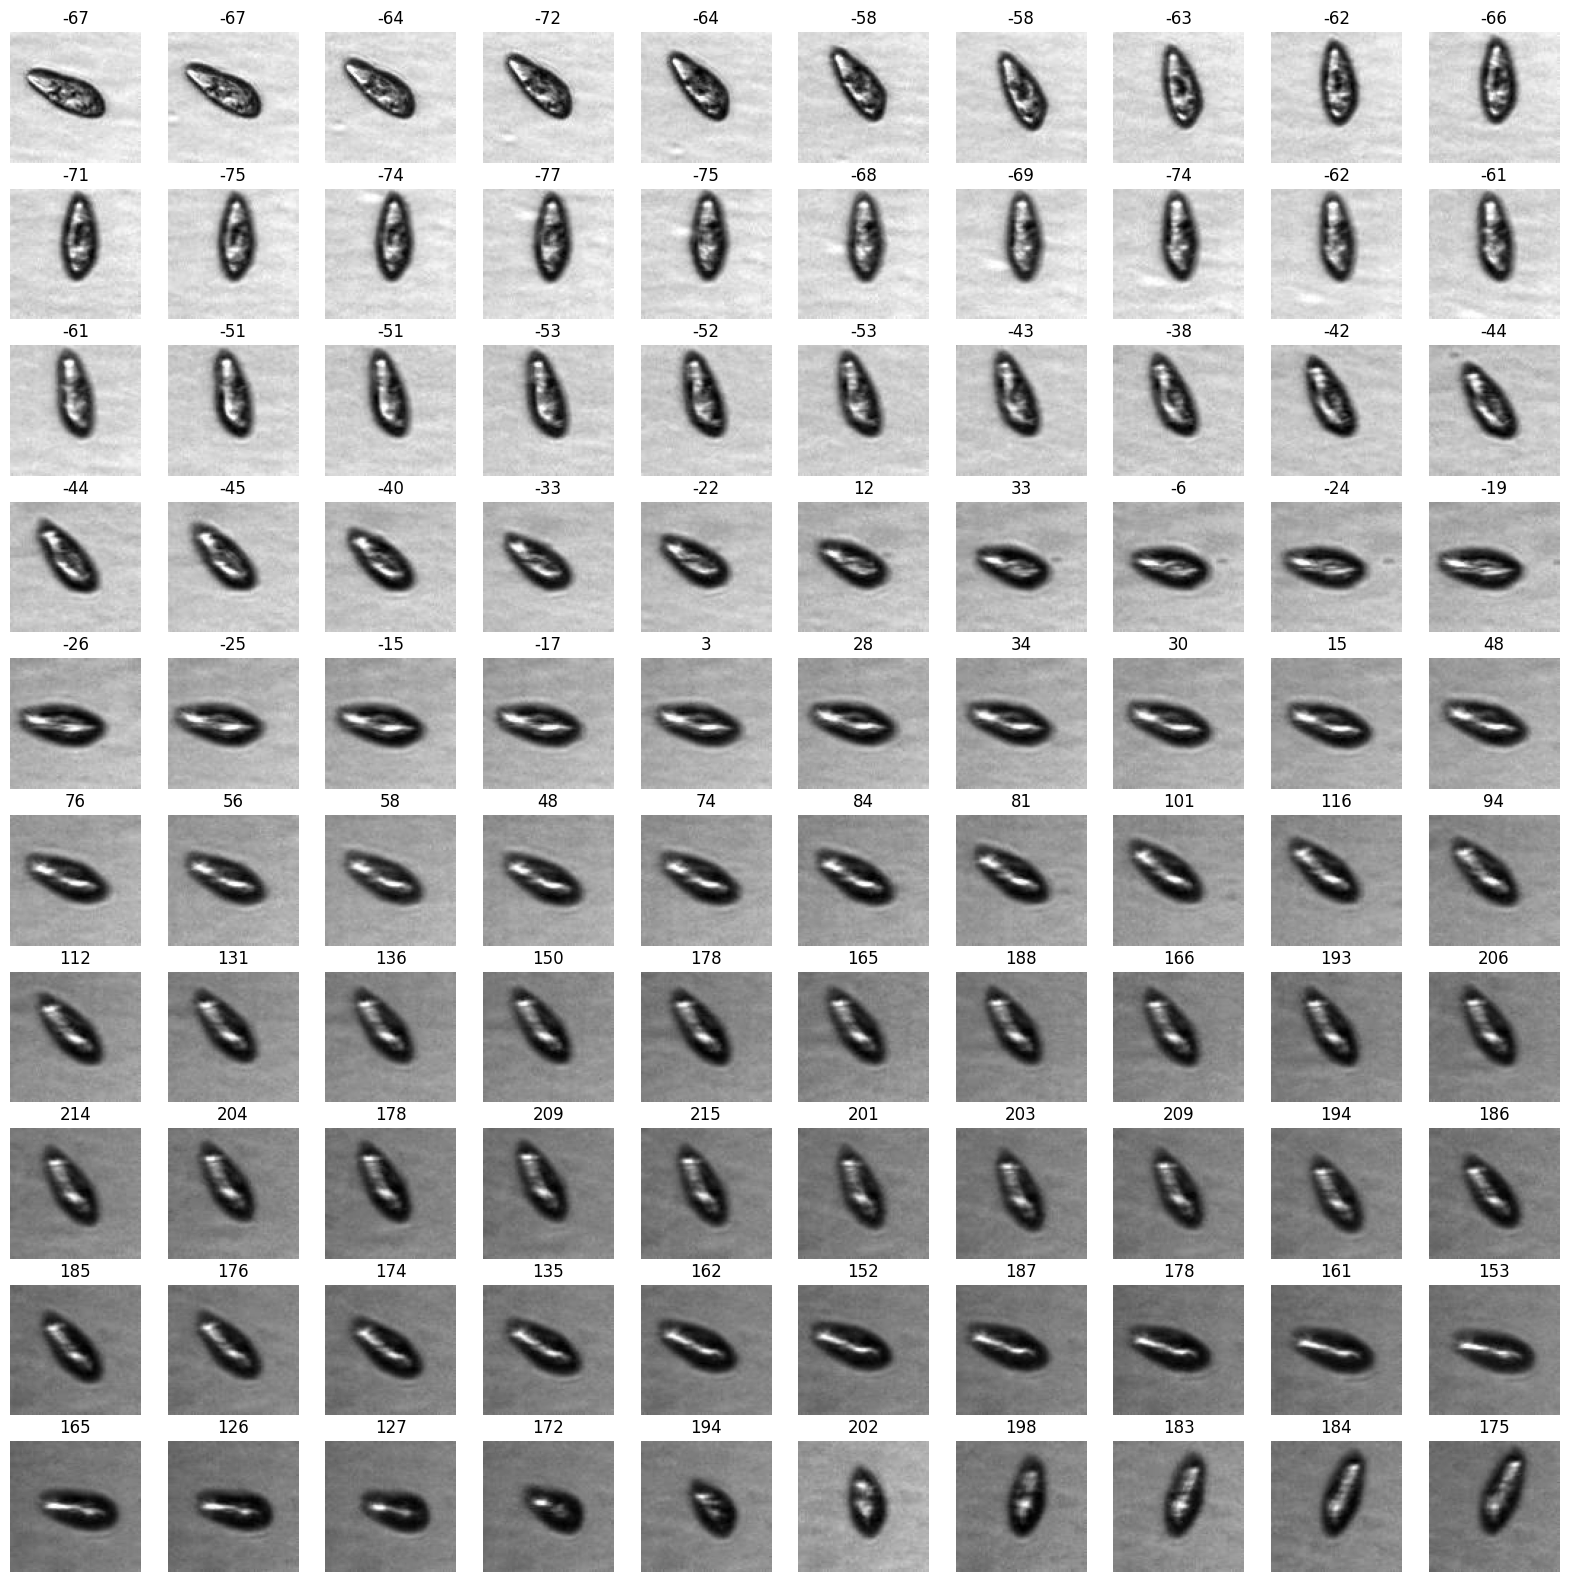

In [36]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(200, 300)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')

/tmp/ipykernel_8417/3319862177.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[j]))


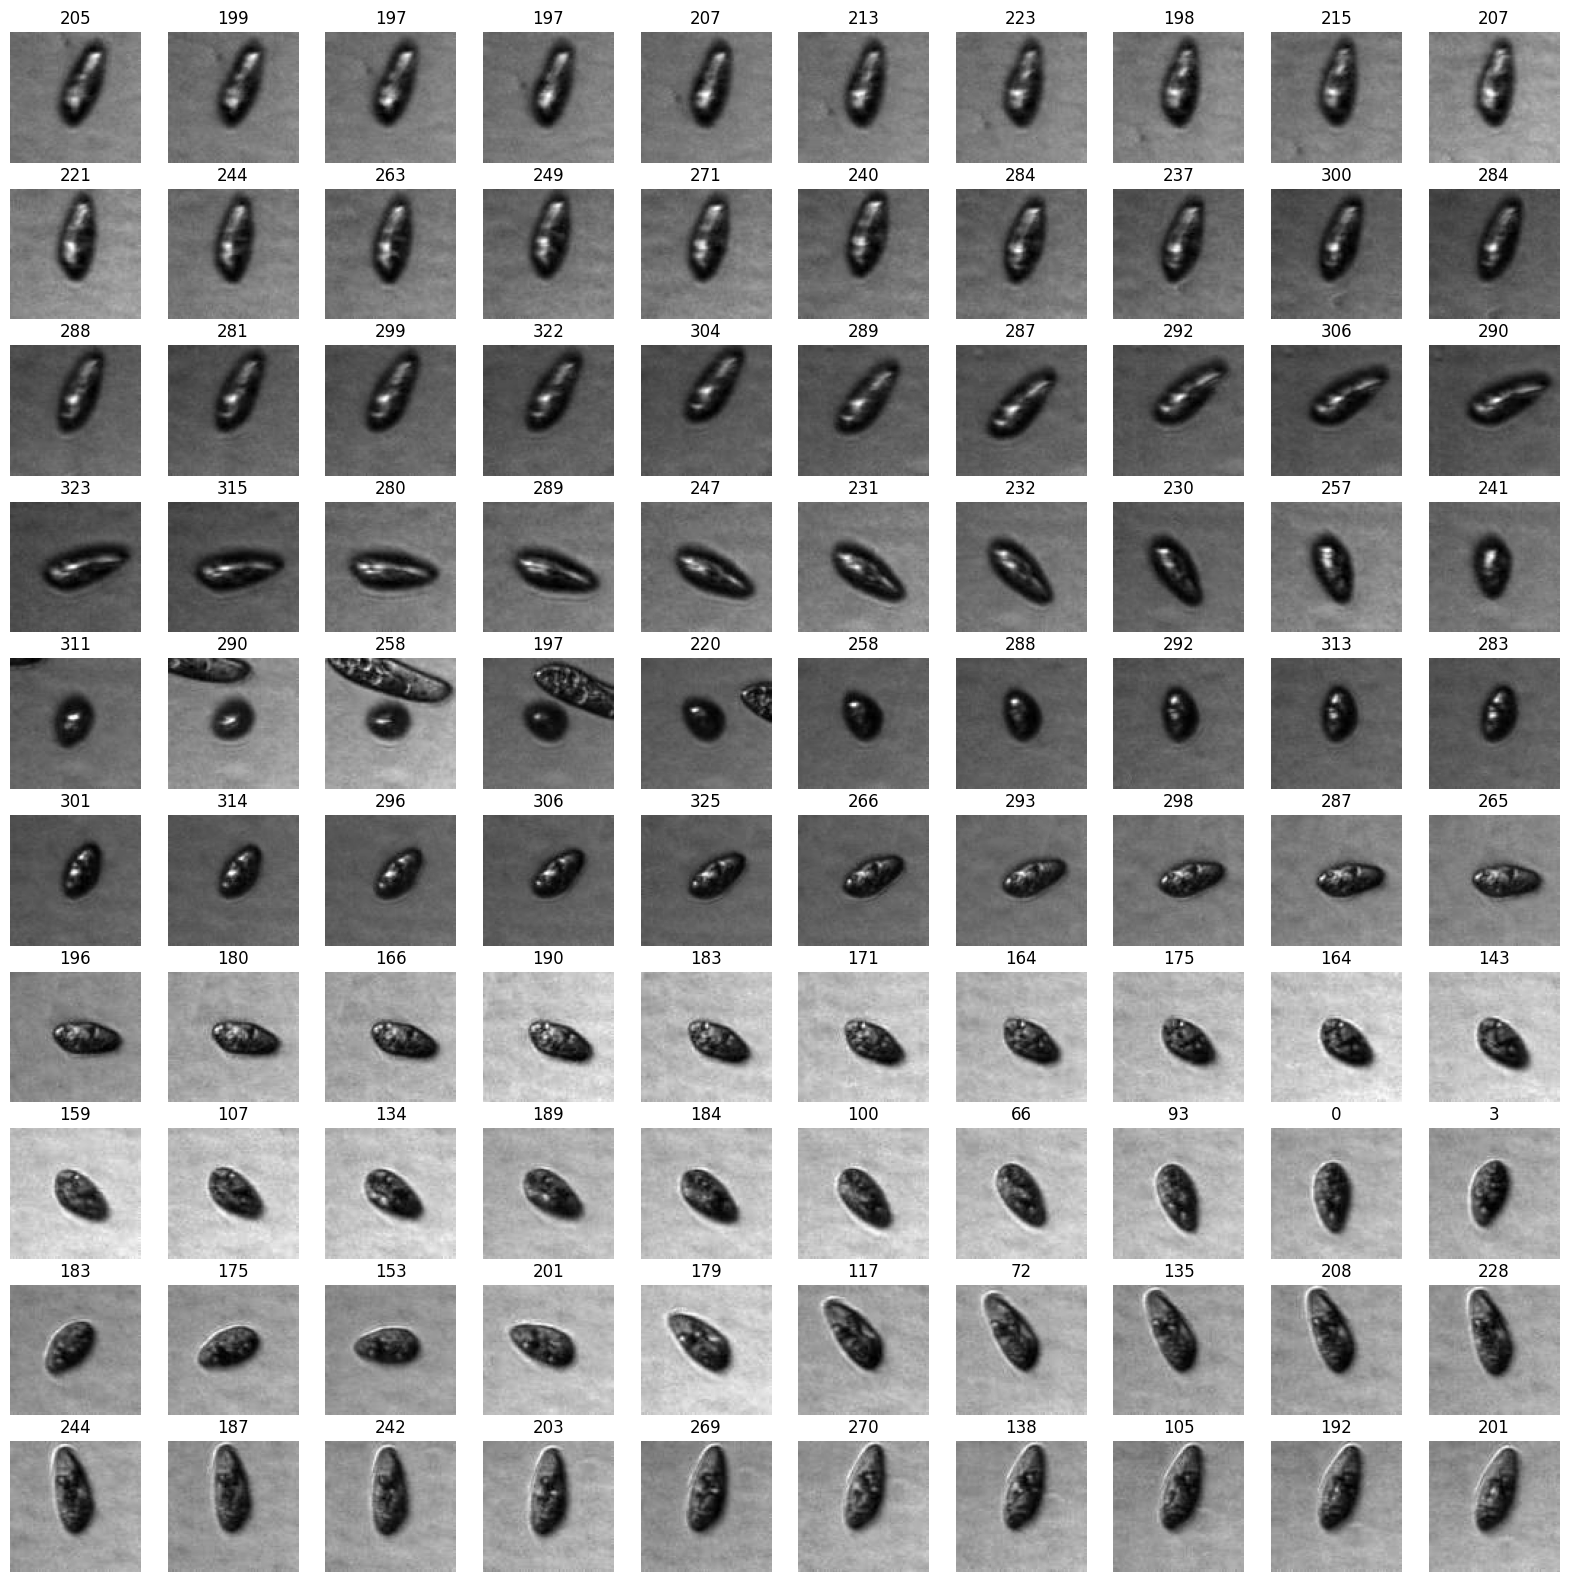

In [37]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(300, 400)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')

/tmp/ipykernel_8417/2565816389.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[j]))


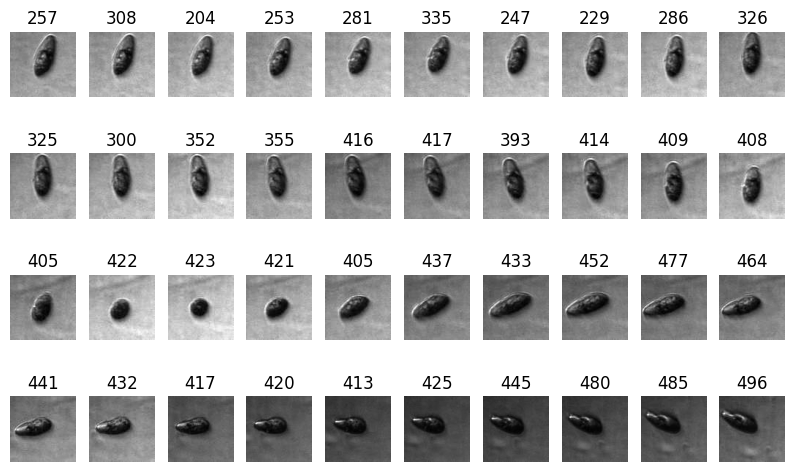

In [41]:
fig, ax = plt.subplots(4, 10, figsize=(10, 10))
for i,j in enumerate(range(400, 440)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')
    #decrease distance betweeen subplots
    plt.subplots_adjust( hspace=-0.7)

In [27]:
#Save yhats to txt
np.savetxt("yhat.txt", yhats, fmt="%s")

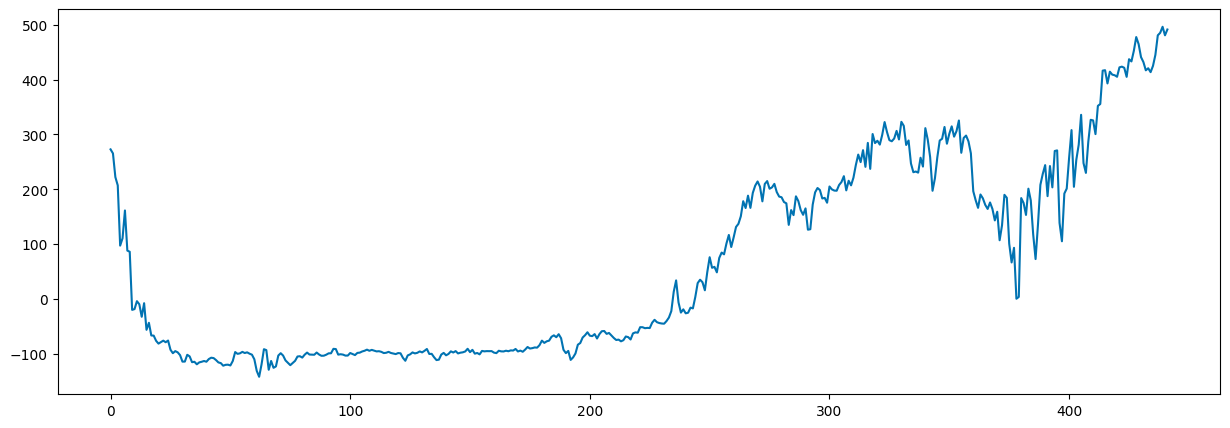

In [28]:
plt.figure(figsize=(15, 5))
plt.plot (yhats)